
# Classify Song Genres from Audio Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#dp">Data Preparing</a></li>
<li><a href="#mt">Model Training</a></li>
<li><a href="#mv">Model Validation</a></li>
<li><a href="#me">Model Evaluation</a></li>
</ul>

<a id='intro'></a>
## Introduction

<b style = color:#4682B4>These recommendations are so on point! How does this playlist know me so well?</b>

<p>
In the era of music streaming, the vast catalogs of services often leave users overwhelmed when seeking new music. To address this, streaming platforms analyze raw audio data to categorize songs and offer personalized recommendations. Using a dataset from The Echo Nest, we aim to classify songs as 'Hip-Hop' or 'Rock' without listening to them. Through data cleaning, exploratory visualization, and feature reduction, we'll employ machine learning techniques like decision trees and logistic regression to achieve this goal.</p>

In [320]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

<a id='dp'></a>
## Data Preparing

### 1. Loading the datase

<p>Let's begin by loading metadata about our tracks and their metrics from The Echo Nest. Beyond titles and artists, we have additional musical features like danceability and acousticness in two files: one in CSV and the other in JSON format. Using pandas, we'll create two DataFrames for these files, merging them to have features and labels (x and y) for our classification task later on.</p>

In [321]:
# Reading the tracks dataset with genel labels
tracks = pd.read_csv("fma-rock-vs-hiphop.csv")
# Reading the track metrics with features
metrics = pd.read_json("echonest-metrics.json")

In [322]:
# Output the first 2 rows of the tracks
tracks.head(2)

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky


In [323]:
# Output the first 2 rows of the metrics
metrics.head(2) 

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240


In [324]:
# Now we will merge the 2 datasets based on the 'track_id'
df = pd.merge(metrics, tracks[['track_id', 'genre_top']], on='track_id')

In [325]:
# Output the summary of our merged dataset and the first 2 rows of it
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop


### 2. Relationships between continuous variables

<p>The goal here to avoid using variables that hava strong correlations with each other to avoid <b style = color:#4682B4>feature redundancy</b></p>

Why do we really do that???
> ##### - To keep the model simple and improve interpretability
> ##### - When the dataset is large, this will improve our computa

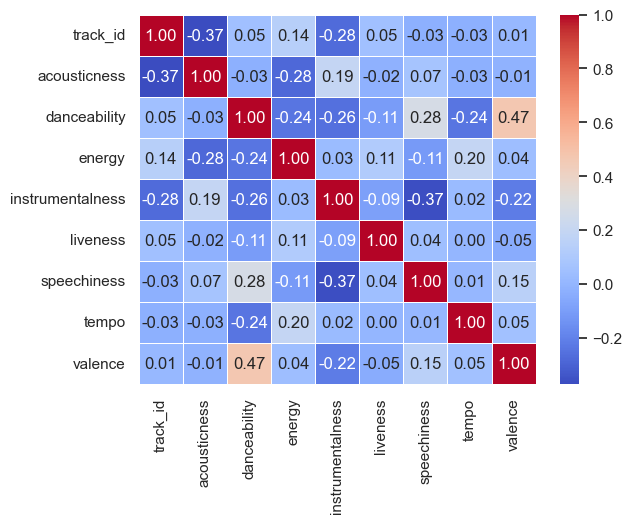

In [326]:
cor = df.corr(numeric_only=True)
sns.heatmap(cor, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.show()

# Positive correlations are represented by warmer colors (closer to 1), typically shades of red.
# Negative correlations are represented by cooler colors (closer to -1), typically shades of blue.
# A correlation of 0 is usually represented by a neutral color (often white or light gray).

<p>We didn't find any particularly strong correlations between our features, so we will move to the next step</p>

### 3. Splitting the data

<p>Next, divide our dataset into two arrays: one containing the features and the other containing the labels (track genres). After this division, we'll proceed with preprocessing steps to enhance our model development.t.</p>

In [327]:
# Drop the "genre_top" and "track_id" columns from the DataFrame and extract the values
features = df.drop(["genre_top", "track_id"], axis=1).values
# Extract the values of the "genre_top" column as labels
labels = df["genre_top"].values
# Split the dataset into training and testing sets
# The train_test_split function shuffles and splits the data into training and testing sets
# The random_state parameter ensures reproducibilbzity of the split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

### 4. Normalizing the feature data

<p>Before proceeding, it's <b>essential</b> to standardize our training and testing features. Standardization, a widely used technique, involves transforming features to have a mean of 0 and a standard deviation of 1. This process, also known as obtaining z-scores, ensures uniform scaling across all features.</p>

In [328]:
# Creates a StandardScaler object.
scaler = StandardScaler()

# Fits the scaler on the training features then transforms them
scaled_train = scaler.fit_transform(train_features)
# Note: This is to ensures that the training features are standardized

# Applies the same transformation to the test features
scaled_test = scaler.transform(test_features)

### 5. PCA on our scaled data

<p>To make our models simpler and more effective, we can use a technique called principal component analysis (PCA). This method helps us identify the most important features that explain the differences between music genres. Think of it like looking at the data from the best angle to understand it better.

However, there's a catch. If a feature has a big range of values, it might have more impact on our analysis. PCA takes this into account, making sure each feature contributes fairly to the overall understanding, regardless of its range.</p>

Text(0.5, 0, 'Principal Component No.')

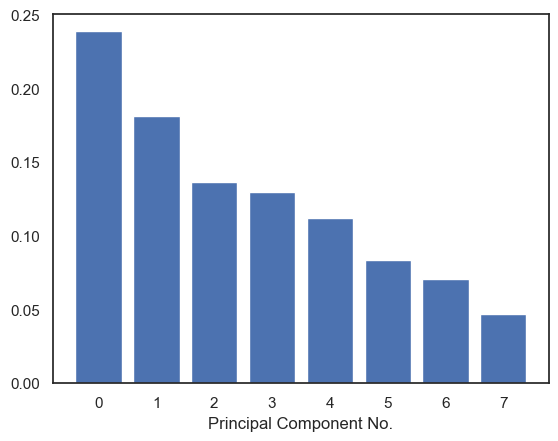

In [329]:
# Create a PCA object
pca = PCA()

# Fitting the model
pca.fit(scaled_train)

# Getting the Explained Variance Ratios for each PC
# These ratios indicate the proportion of the dataset's 
# total variance that is explained by each PC
exp_var = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, a = plt.subplots()
a.bar(range(pca.n_components_), exp_var)
a.set_xlabel('Principal Component No.')

<p>The explained variance ratio indicates the proportion of the total variance in the dataset that is explained by each principal component. <br> 
So here for example:</p>

> ##### - PC1: Approximately 24% of the total variance is explained by the first principal component. 
> ##### - PC2: Approximately 18% of the tota...... 

And so on. <br> <br>
Regrettably, the scree plot doesn't exhibit a distinct elbow, making it challenging to determine the optimal number of intrinsic dimensions through this approach. <br><Br>
<p style = color:#4682B4>Note: The "elbow" in the scree plot of a principal component analysis (PCA) indicates the optimal number of principal components to retain, balancing explained variance and model simplicity.</p>

### 6. More visualization of PCA

<p>Since there is no distinct elbow in the scree plot, determining the optimal number of intrinsic dimensions using this method is not straightforward. Instead, we can turn to the cumulative explained variance plot, aiming to choose a number of features that account for a certain percentage (let's say 85% [a threshold]) of the total variance, thereby reducing the dimensionality of the data.</p>

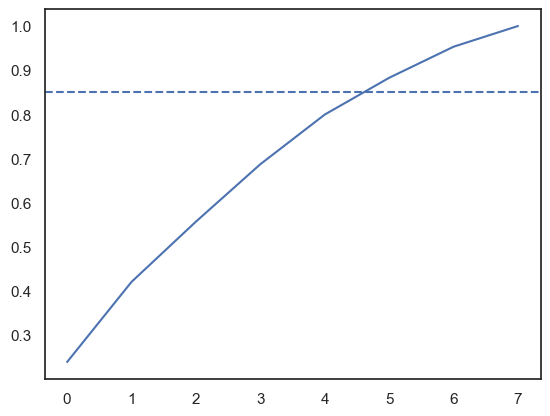

In [330]:
# Computes the cumulative sum of the explained variance ratios obtained from the PC.
cum_exp_var = np.cumsum(exp_var)

# Creates a new figure and axis for plotting
fig, ax = plt.subplots()

# Plots the cumulative explained variance
ax.plot(cum_exp_var)
# Here each point on the plot represents the cumulative proportion of
# total variance explained by including more PC.

# Draws a dashed line at the 0.85 mark on the y-axis.
ax.axhline(y=0.85, linestyle='--')
# This line serves as a reference for identifying the point at which the 
# cumulative explained variance reaches or surpasses 85%.


<p>The cumulative explained variance plot indicates that including approximately 6 PCs is sufficient to capture 85% of the total variance in the dataset. This suggests that a reduced set of 6 PCs retains a significant portion of the original dataset's variability, making it a <b style = color:#4682B4>reasonable</b> choice for dimensionality reduction.</p>

### 7. Transforming onto our features

<p>So, utilizing 6 components in PCA allows us to reduce the dimensionality of our training and testing features.</p>

In [331]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components=6, random_state=10)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(scaled_test)

<a id='mt'></a>
## Models Training

### 1. Train a Decision Tree Model

<p>Now, we can use the simplified PCA projection to classify songs into genres, employing a decision tree algorithm. Decision trees, being rule-based classifiers, use a 'tree structure' of binary decisions to categorize data points. They are easy to use, interpret, and visualize, providing a 'logic flowchart' generated from the training data.</p>


In [332]:
# Create a decision tree classifier object
tree_classifier = DecisionTreeClassifier(random_state=10)

# Train the classifier on the train_pca
tree_classifier.fit(train_pca, train_labels)

# After training, the decision tree is used to predict the labels for the test data
pred_tree = tree_classifier.predict(test_pca)

### 2. Train a Logistic Regression Model

<p>It's important to explore different models as the current one might not be the best fit. Introducing logistic regression, which uses the logistic function for probability calculation, allows us to compare models based on metrics like false positives and false negatives to evaluate their performance and accuracy.</p>

In [333]:
# Creates a logistic regression model object
logreg = LogisticRegression(random_state=10)

# Train the model on the train_pca
logreg.fit(train_pca, train_labels)

# After training, the logistic regression model is used to predict the labels for the test data
pred_logit = logreg.predict(test_pca)

<a id='mv'></a>
## Model Validation

### 1. Comparing the models

In [334]:
# Here we want to generate classification reports for evaluating the performance of our models using 
# the actual and predicted labels from the test set
rep_tree = classification_report(test_labels, pred_tree)
rep_log = classification_report(test_labels, pred_logit)

# Printing the reports
print("Decision Tree: \n", rep_tree)
print("Logistic Regression: \n", rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.63      0.62      0.62       235
        Rock       0.91      0.91      0.91       966

    accuracy                           0.85      1201
   macro avg       0.77      0.77      0.77      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



<p>Both models are doing well. However, when we look closely at the results, we see that rock songs are mostly identified correctly, but hip-hop songs are often mistakenly labeled as rock. This could be because we have a lot more rock songs in our data, making it harder for the models to tell them apart. Essentially, our models are mostly good at recognizing rock songs, but not as great at identifying hip-hop songs, and that's not ideal.</p>

### 2. Balancing The data

<p>To fix this issue, we can give more importance to accurately classifying the less common type of music (Hip-Hop) by adjusting our evaluation criteria. This ensures that our model's performance isn't overly influenced by the larger number of Rock songs, and we aim for balanced accuracy between the two music genres.</p>

In [335]:
# Select rows where genre is 'Hip-Hop'
hip = df.loc[df['genre_top'] == 'Hip-Hop']

# Select a random sample of rows where genre is 'Rock' with the same length as 'Hip-Hop'
temp_rock = df.loc[df['genre_top'] == 'Rock']
hip_length = hip.shape[0]
rock = temp_rock.sample(hip_length, random_state=10)

# Concatenate the 'Rock' and 'Hip-Hop' samples to create a new balanced dataset
rock_hop = pd.concat([rock, hip])

# Extract features and labels
features = rock_hop.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop['genre_top']

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

# Apply PCA and scaling to the training and testing features
train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

<p>After balancing the dataset there are few things to keep in mind:</p>

> 1- Concerns about Data Loss
>>  Acknowledges that by balancing the dataset, some data points were removed, and these points could be valuable for training the models.

> 2- Testing Model Bias
>> Proposes testing to see if the balancing process improves bias in the models toward the "Rock" classification.
>> 
>> Implies that the initial dataset might have had a bias toward one class (potentially "Hip-Hop"), and balancing aims to address this.

> 3- Decision on Dimensionality Reduction
>> For this analysis, dimensionality reduction won't be applied, as the dataset size has already been reduced, and the focus is on evaluating the impact of balancing.


<p  style = color:#4682B4>Note: Dimensionality reduction is usually considered more rigorously when dealing with very large datasets or when computational constraints become a limiting factor.</p>

### 3. Retrain The models

In [336]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)
pred_tree = tree.predict(test_pca)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_logit = logreg.predict(test_pca)

# compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.77      0.79       230
        Rock       0.78      0.82      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.83      0.82      0.82       455



<b  style = color:#DA2C43>Achievement unlocked! Balancing our dataset successfully eliminated bias towards the more commonly occurring class.</b>

<a id='me'></a>
## Model Evaluation

### 1. Cross-Validation to evaluate the models

<p>To make sure our models are performing well, we're using a technique called cross-validation (CV). This method helps us compare different models more accurately. <br>

Here's how it works: We create pipelines to prepare our data and set up our models. Then, instead of just one train-test split, we divide our data into K equal parts. We train and test our models multiple times, each time using a different part as the test set. Finally, we gather all the results to get an overall performance score for our models.</p>

In [337]:
# Create a pipeline for Decision Tree classifier
t_pipe = Pipeline([
    ("scaler", StandardScaler()),          # Standardize features
    ("pca", PCA(n_components=6)),          # Apply PCA for dimensionality reduction
    ("tree", DecisionTreeClassifier(random_state=10))  # Decision Tree Classifier
])

# Create a pipeline for Logistic Regression classifier
l_pipe = Pipeline([
    ("scaler", StandardScaler()),                # Standardize features
    ("pca", PCA(n_components=6)),                # Apply PCA for dimensionality reduction
    ("logreg", LogisticRegression(random_state=10))  # Logistic Regression Classifier
])

# Set up K-fold cross-validation with 10 folds
kf = KFold(10)

# Train Decision Tree and Logistic Regression models using KFold cross-validation
t_score = cross_val_score(t_pipe, features, labels, cv=kf)
l_score = cross_val_score(l_pipe, features, labels, cv=kf)

# Print the mean accuracy of each model
print(f"Decision Tree: {np.mean(t_score):.2%} | Logistic Regression: {np.mean(l_score):.2%}")

Decision Tree: 75.82% | Logistic Regression: 78.30%


>  Decision Tree
>> On average, the Decision Tree model correctly predicted the genre of a track approximately 75.82% of the time during cross-validation.

> Logistic Regression
>> On average, the Logistic Regression model achieved an accuracy of about 78.30% during cross-validation.

<p style = color:#6f402b>Comparing the two, the <b>Logistic Regression model</b> appears to have a slightly <b>higher mean accuracy</b>, suggesting it performed slightly better on average during the cross-validation process.</p>